# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Note:** All Student's notes are decorated with 📌 emoji.

#### 📌 Translate Business Objectives to Data Analysis Objectives

As a data analyst to find answers for the above business objectives (to identify key features driving the Vehicle Price) I need to:
* Fit and measure performance of a few models to predict the Price. Tune the models's hyper-parameters. Finally, pick the most optimal model.
* Then analyze coefficients of the most optimal model for the car features to provide answers to the business objectives.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### 📌 Load necessary libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

# Configure Pandas to display float types in more readable format using a custom callback.
pd.set_option('display.float_format', lambda input_float: '%3f' % input_float)

#### 📌 Load the data and describe it

In [2]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
df.isna().mean().sort_values()

id             0.000000
price          0.000000
state          0.000000
region         0.000000
year           0.002823
transmission   0.005988
fuel           0.007058
odometer       0.010307
model          0.012362
title_status   0.019308
manufacturer   0.041337
type           0.217527
paint_color    0.305011
drive          0.305863
VIN            0.377254
condition      0.407852
cylinders      0.416225
size           0.717675
dtype: float64

📌 Insight:
* There is quite a bit of missing values. This will need to be addressed by dropping an offending feature or by data imputation.
* Columns VIN or ID do not influence Vehicle Price and can be dropped altogether.
* Column `year` is encoded as `float` type which does not make sense as it is a scalar. This feature could be also converted to a more meaningful `age` feature -> `age = <current year> - <car model year>`. 

In [4]:
df.sample(10, random_state = 44)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
16314,7311624350,tucson,0,2020.000000,dodge,challenger,NaN,NaN,gas,11251.000000,clean,automatic,2C3CDZBT1LH196306,NaN,NaN,NaN,NaN,az
26545,7313968849,fresno / madera,21995,2011.000000,ford,f-250,excellent,NaN,diesel,176000.000000,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
361837,7313097680,tri-cities,6500,2013.000000,hyundai,veloster,good,4 cylinders,gas,131000.000000,clean,automatic,NaN,fwd,compact,hatchback,black,tn
48536,7316774532,reno / tahoe,0,2006.000000,ford,f-150 fx4 fx4 4dr supercab,NaN,8 cylinders,gas,289162.000000,clean,automatic,1FTPX14576FA16983,4wd,NaN,truck,NaN,ca
367989,7308254751,corpus christi,20507,2014.000000,audi,q5,NaN,6 cylinders,diesel,76479.000000,clean,automatic,WA1CMAFP5EA078135,4wd,mid-size,SUV,grey,tx
285829,7310589234,new hampshire,99,2018.000000,hyundai,elantra,NaN,NaN,gas,27180.000000,clean,automatic,5NPD84LF8JH389623,fwd,full-size,sedan,grey,nh
232570,7314438891,charlotte,10000,1950.000000,gmc,NaN,NaN,6 cylinders,gas,20000.000000,clean,manual,NaN,rwd,NaN,pickup,NaN,nc
180380,7308039947,maine,15995,2009.000000,toyota,tacoma,excellent,NaN,gas,152000.000000,clean,automatic,3TMLU42N69M028994,4wd,NaN,pickup,brown,me
219267,7316627934,columbia / jeff city,11500,1929.000000,NaN,Model A,good,4 cylinders,gas,10000.000000,clean,manual,NaN,rwd,mid-size,pickup,yellow,mo
135098,7303259715,lewiston / clarkston,3500,2006.000000,NaN,Milan,good,4 cylinders,gas,120000.000000,clean,manual,NaN,fwd,NaN,sedan,black,id


In [5]:
df.describe()

,id,price,year,odometer
count,426880.000000,426880.000000,425675.000000,422480.000000
mean,7311486634.224333,75199.033187,2011.235191,98043.331443
std,4473170.412559,12182282.173604,9.452120,213881.500798
min,7207408119.000000,0.000000,1900.000000,0.000000
25%,7308143339.250000,5900.000000,2008.000000,37704.000000
50%,7312620821.000000,13950.000000,2013.000000,85548.000000
75%,7315253543.500000,26485.750000,2017.000000,133542.500000
max,7317101084.000000,3736928711.000000,2022.000000,10000000.000000


📌 Insight:
* There are some really bogus entires.
* Minimum `price` is 0; `year` - 1900; `odometer` - 0.0
* Maximum `price` is 3,736,928,711; `odometer` - 10,000,000.

##### 📌 Analyze the Price ($) data 

Vehicle Price is the univariate we need to predict. It is important to examine its distribution. The closer it is to normal distribution the better will be our models.

Number of records with Price value <= 0:  32895
Number of records with Price value > 100,000:  655


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of Price variable < $100,000')]

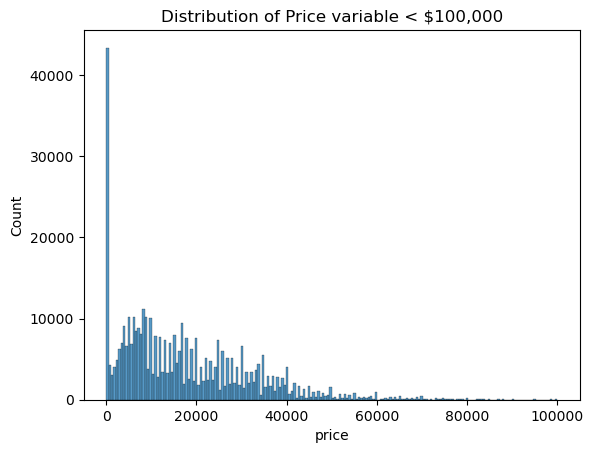

In [6]:
print('Number of records with Price value <= 0: ', df.query('price <= 0')['price'].count())
print('Number of records with Price value > 100,000: ', df.query('price > 100_000')['price'].count())
sns.histplot(data = df.query('price < 100_000')['price']).set(title = 'Distribution of Price variable < $100,000')

📌 Clearly Vehicle Price variable is not normally distributed. There is a lof of outliers. Primarily 0-values but there are also some very expensive exotic cars. This will need to be addressed in the data preparation phase. 

##### 📌 Other Vehicle Features

[Text(0.5, 1.0, 'Distribution of vehicle production year')]

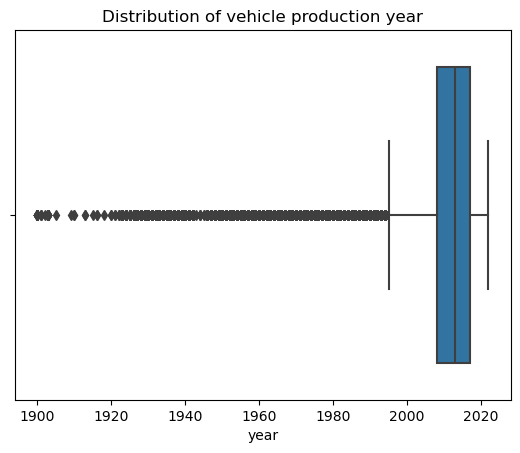

In [7]:
sns.boxplot(data = df, x = 'year').set(title = 'Distribution of vehicle production year')

📌 We will need to address cars with bogus `year` entries. 1900 is not the only one bogus value as found earlier. I think we should drop cars manufactured before year 2000. Antics market is a separate and speculative domain on its own and outside of our business objective. 

In addition we can convert `year` to something like `age` to better express the negative impact vehicle's `age` has on its `price`. 

[Text(0.5, 1.0, 'Distribution of vehicle odometer')]

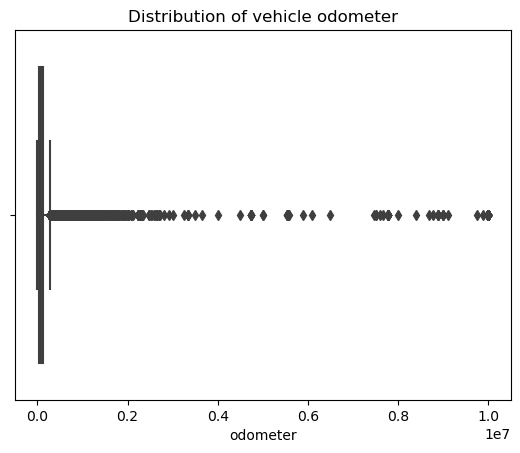

In [8]:
sns.boxplot(data = df, x = 'odometer').set(title = 'Distribution of vehicle odometer')

📌 Similarly to `year`, we will need to discard entries with bogus `odometer` entries. Probably over 200,000 miles is a reasonable cut off value.

In [9]:
df['cylinders'].value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

📌 We can convert cylinders to numerical type. Then decide if we still need it. It seems like an important driver of a car price (characterizes engine performance) but also there's a lot of missing values. 42% of data is missing.

In [10]:
df['size'].value_counts()

size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64

📌 Car size might be another important feature but 72% of data is missing. 

In [11]:
df['title_status'].value_counts()

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

📌 Only 2% if data is missing. We could use Ordinal Encoding. Perhaps remove `missing` and `parts only` vehicles or only focus on `clean` titles too.

In [12]:
df['transmission'].value_counts()

transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64

📌 Only 0.6% of data is missing but I don't think this data is relevant in the US. In Europe, for example, Automatic transmission cars are unpopular.

In [13]:
df['drive'].value_counts()

drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64

📌 31% of data missing. Seems irrelevant.

In [14]:
df['condition'].value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

📌 40% of data is missing. However, `condition` seems essential in Vehicle Price evaluation.

In [15]:
df.groupby('state')['price'].mean().sort_values(ascending = False)

state
de   3205055.885142
tn    369348.025574
nj    325456.544755
md    312340.387191
al    239642.532190
in    235833.069425
or    234168.891370
ga    159261.228474
ca    120121.124590
ok     36207.101443
id     35638.497489
nc     32828.723440
mi     30072.554438
oh     26833.671960
ut     25099.976522
wv     24317.416350
ak     23745.823258
mt     23515.942326
nd     22326.348780
wa     22221.343554
tx     21344.024450
wy     21104.073770
mo     20872.681342
nv     20574.807138
hi     19742.604588
az     19482.617928
ky     19061.847192
nm     19041.866441
ks     18954.528749
sc     18823.202782
ne     18701.601351
sd     18369.448541
co     18117.450307
ar     18061.280832
la     17929.547872
fl     17852.280137
nh     17645.675277
ms     17609.733268
ny     16976.520118
vt     16579.095105
il     16559.761914
wi     16529.628268
ri     16424.106466
ia     16183.885774
mn     16037.204769
ma     15582.394421
pa     15542.140915
ct     15039.162876
dc     14480.132323
va     13877.0

📌 It looks like in Delaware there's a lot of expensive car sales.

<Axes: >

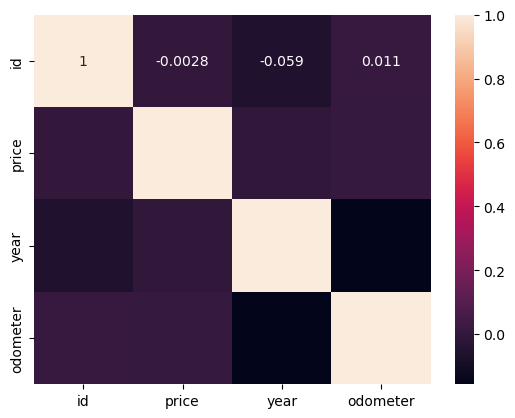

In [16]:
corr = df.corr(numeric_only = True)
sns.heatmap(data = corr, annot = True)

📌 Nothing interesting here. Correlation analysis will make more sense after the data cleanup.

In [17]:
df.duplicated().sum()

0

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [18]:
# Make a "deep" copy from the original DataFrame. Simple assignment does only a "shallow" copy.
veh = df.copy()

📌 Handle outliers and perform early transformations

In [19]:
# Remove cars older than year 2000. Also add new column 'age'. Since max 'year' is 2022 we will bias the 'age' at 2022.
veh = veh.query('year >= 2000')
veh['age'] = 2022 - veh['year'].dropna().astype(np.int32)
# Finally, remove year column since we have age.
veh.drop(columns = ['year'], inplace = True)

In [20]:
# Remove cars with mileage over 200k miles.
veh = veh.query('odometer <= 200_000')

In [21]:
# Keep entries where price is in range: ~500 - ~300,000
# Also convert price to log() to get normal distribution.
veh = veh.query('(price >= 1_000) and (price <= 200_000)')
veh['price'] = np.log(veh['price'])

📌 Drop columns, NaNs and duplicates

In [22]:
# Drop columns with not much relevant data.
veh.drop(columns = ['id', 'VIN', 'fuel', 'model'], inplace = True)

# Drop columns with majority of missing data.
veh.drop(columns = ['size', 'cylinders', 'condition', 'drive', 'paint_color', 'type'], inplace = True)

# Drop categorical columns that would just increase number of features
veh.drop(columns = ['transmission', 'manufacturer', ], inplace = True)

In [23]:
# Drop all remaining NaNs.
veh.dropna(inplace = True)

# Drop leftover duplicates.
veh.drop_duplicates(keep = False, inplace = True)

📌 Last final check

In [24]:
veh.info()
veh.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 260313 entries, 27 to 426879
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        260313 non-null  object 
 1   price         260313 non-null  float64
 2   odometer      260313 non-null  float64
 3   title_status  260313 non-null  object 
 4   state         260313 non-null  object 
 5   age           260313 non-null  int32  
dtypes: float64(2), int32(1), object(3)
memory usage: 12.9+ MB


,price,odometer,age
count,260313.000000,260313.000000,260313.000000
mean,9.665603,81489.784855,8.779220
std,0.805931,54529.363200,4.971439
min,6.907755,0.000000,0.000000
25%,9.104424,32086.000000,5.000000
50%,9.797571,76996.000000,8.000000
75%,10.308386,124984.000000,12.000000
max,12.206073,200000.000000,22.000000


(426880, 18)
0
(260313, 6)
0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of log(Price)')]

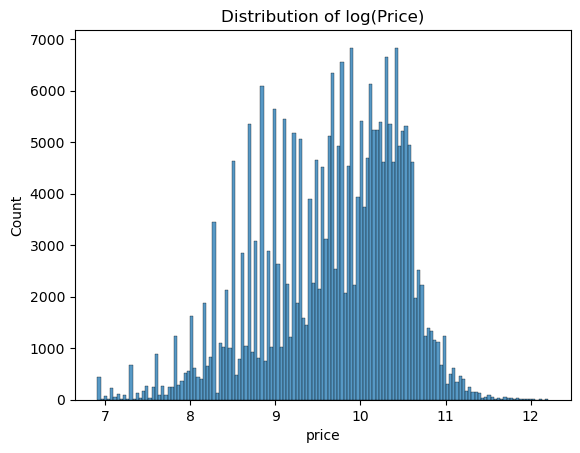

In [25]:
print(df.shape)
print(df.duplicated().sum())
print(veh.shape)
print(veh.duplicated().sum())
sns.histplot(data = veh['price']).set(title = 'Distribution of log(Price)')

📌 After logarithmic transformation of the `price` column we see normal distribution pattern emerging.

<Axes: >

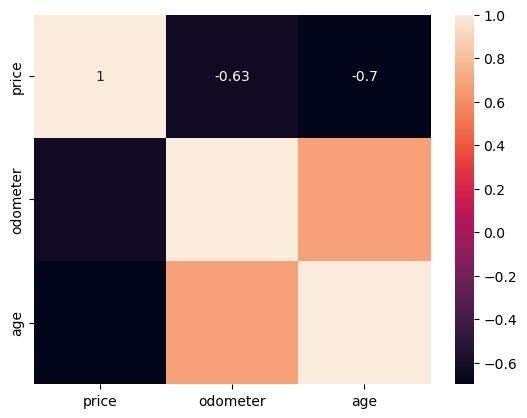

In [26]:
corr = veh.corr(numeric_only = True)
sns.heatmap(data = corr, annot = True)

📌 After data cleaning and data conversion we see very strong negative corelation between car's age and odometer reading against its price.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.